In [620]:
import os
from OCC.Display.SimpleGui import init_display
from OCC.Extend.DataExchange import read_iges_file

def read_file(path, is_display=False):
    
    if os.path.exists(path):           # 防止路徑不存在
        shapes = read_iges_file(path)  # 一定要用這個方法讀取
    else:
        print("檔案路徑錯誤！")
    
    if is_display:
        # 初始化 3D 顯示環境
        display, start_display, add_menu, add_function_to_menu = init_display()
        display.DisplayShape(shapes, update=True)
        start_display()
        
    return shapes

In [621]:
path = r"C:\alan\ITRI\ITRI-test\model\HCG_faucet_LF3188.IGS"
# path = r"C:\alan\ITRI\ITRI-test\model\complex_3.IGS"
object_1 = read_file(path, is_display=True)
object_1=object_1[0]

In [622]:
import os
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopoDS import topods
from OCC.Core.TopAbs import TopAbs_FACE
from OCC.Display.OCCViewer import OffscreenRenderer

# 平面影像儲存路徑
# image_directory = r"C:\NTHU\IRTI-Project\Images"

def plane_segmentation(object, is_save=True):
    
    explorer = TopExp_Explorer(object, TopAbs_FACE) # TopAbs_FACE 只對面感興趣
    faces = []
    index = 1
    # # 宣告一個渲彩器(不會顯示出來)
    # renderer = OffscreenRenderer()
    # renderer.Create()
    
    while explorer.More():
        
        face = topods.Face(explorer.Current())
        faces.append(face)                     # 將當前的面儲存到 list 中

        index += 1
        explorer.Next()                      # 移動到下一個面
    
    return faces

In [623]:
object_1_faces = plane_segmentation(object_1)
print("object_1 總共有", len(object_1_faces), "個物件")

object_1 總共有 100 個物件


In [624]:
from OCC.Core.BRepGProp import brepgprop_SurfaceProperties
from OCC.Core.GProp import GProp_GProps
from OCC.Core.TopoDS import TopoDS_Shape

def calculate_surface_area(shape):
    # 將 shape 轉換為 TopoDS_Shape
    topods_shape = TopoDS_Shape(shape)

    # 初始化表面屬性
    surface_props = GProp_GProps()

    # 計算表面屬性
    brepgprop_SurfaceProperties(topods_shape, surface_props)
    
    # 獲取表面積
    surface_area = surface_props.Mass()

    return surface_area

In [625]:
#確定法向量方向
from OCC.Core.gp import gp_Pnt
from OCC.Core.GC import GC_MakeSegment
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeEdge, BRepBuilderAPI_MakeWire
from OCC.Core.gp import gp_Pnt, gp_Vec, gp_Dir,gp_Circ, gp_Ax2, gp_Pnt
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeEdge, BRepBuilderAPI_MakeWire,BRepBuilderAPI_MakeFace
from OCC.Core.BRepOffsetAPI import BRepOffsetAPI_MakePipe
from OCC.Display.SimpleGui import init_display
import numpy as np
from OCC.Core.IGESControl import IGESControl_Reader
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeEdge
from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Section
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_VERTEX
from OCC.Core.BRep import BRep_Tool
from OCC.Extend.DataExchange import read_iges_file
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface
from OCC.Core.BRepLProp import BRepLProp_SLProps

def check_normal_vector_direction(face,model):

    adaptor_surface = BRepAdaptor_Surface(face, True)
    props = BRepLProp_SLProps(adaptor_surface, 2, 0.01)
    u_min, u_max, v_min, v_max = adaptor_surface.FirstUParameter(), adaptor_surface.LastUParameter(), adaptor_surface.FirstVParameter(), adaptor_surface.LastVParameter()
    u_mid = (u_min + u_max) / 2
    v_mid = (v_min + v_max) / 2
    props.SetParameters(u_mid, v_mid)
    center = adaptor_surface.Value(u_mid, v_mid)
    normal=None
    if props.IsCurvatureDefined():
        normal = props.Normal()  
    else:
        print(normal) 
         
    # if projector.NbPoints() > 0:
    #     u, v = projector.LowerDistanceParameters()
    
    # else:
    #     print("No projection found for this point")        
    #     props.SetParameters(u, v)
    #     if props.IsCurvatureDefined():
    #         normal = props.Normal()
    # 創建一條線段
    point_s=gp_Pnt(center.X(),center.Y(), center.Z())

    point_e=gp_Pnt(float(center.X()+10000*normal.X()),float(center.Y()+10000*normal.Y()), float(center.Z()+10000*normal.Z()))
    line = BRepBuilderAPI_MakeEdge(point_s, point_e).Edge()

    # 計算交點
    section = BRepAlgoAPI_Section(line, model)
    section.Build()

    # 提取交點
    intersection_points = []
    if section.IsDone():
        ex = TopExp_Explorer(section.Shape(), TopAbs_VERTEX)
        while ex.More():
            vertex = ex.Current()
            point = BRep_Tool.Pnt(vertex)
            intersection_points.append(point)
            ex.Next()

    # 打印交點數量和座標
    # print(f"Number of intersection points: {len(intersection_points)}")

    
    # print(f"Number of intersection points: {len(intersection_points)}")
    # for point in intersection_points:
    #     print(f"Intersection point: ({point.X()}, {point.Y()}, {point.Z()})")
        
    if len(intersection_points)%2==0:
        return 0
    else :
        return 1

In [626]:
import os
import numpy as np
from OCC.Core.IGESControl import IGESControl_Reader
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopoDS import topods_Face, TopoDS_Face, TopoDS_Shape
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface
from OCC.Core.BRepLProp import BRepLProp_SLProps
from OCC.Core.TopoDS import topods_Edge
from OCC.Core.TopAbs import TopAbs_FACE
from OCC.Core.TopAbs import TopAbs_EDGE
from OCC.Core.gp import gp_Pnt, gp_Vec
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeEdge, BRepBuilderAPI_MakeVertex
from OCC.Core.Bnd import Bnd_Box
from OCC.Core.BRepBndLib import brepbndlib_Add
from OCC.Core.gp import gp_Pnt
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape
from OCC.Display.OCCViewer import rgb_color
from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Lin
from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Section
from OCC.Core.TopAbs import TopAbs_VERTEX
from OCC.Core.BRep import BRep_Tool
import csv
import numpy as np
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface
from OCC.Core.BRepLProp import BRepLProp_SLProps
from OCC.Core.TopoDS import topods
from OCC.Core.TopAbs import TopAbs_FACE
def sample_feature_points(face,data,feature): 
    
    face = topods.Face(face)
    check_normal=check_normal_vector_direction(face,object_1)
    adaptor_surface = BRepAdaptor_Surface(face, True)
    props = BRepLProp_SLProps(adaptor_surface, 2, 0.01)
    # 計算面積
    surface_area = GProp_GProps()
    brepgprop_SurfaceProperties(face, surface_area)
    area = surface_area.Mass()
    # print(area)

    # 根据面积和密度计算采样点数量
    density_per_unit_area=0.2
    num_points = int(area * density_per_unit_area)
    num_u_points = num_v_points = int(np.sqrt(num_points))


    u_min, u_max, v_min, v_max = adaptor_surface.FirstUParameter(), adaptor_surface.LastUParameter(), adaptor_surface.FirstVParameter(), adaptor_surface.LastVParameter()

    u_values = np.linspace(u_min, u_max, num=num_u_points)
    v_values = np.linspace(v_min, v_max, num=num_v_points)
    
    for u in u_values:
        for v in v_values:
            position=adaptor_surface.Value(u, v)
            point = BRepBuilderAPI_MakeVertex(adaptor_surface.Value(u, v)).Vertex()
            # 計算該點到曲面的最小距離
            dist_shape_shape = BRepExtrema_DistShapeShape(point, face)
            min_distance = dist_shape_shape.Value()
            if min_distance < 0.001:
                x=position.X()#點座標
                y=position.Y()
                z=position.Z()
                u_mid = (u_min + u_max) / 2
                v_mid = (v_min + v_max) / 2
                props.SetParameters(u, v)


                if props.IsCurvatureDefined():
                    normal = props.Normal()#點法向量
                    # if face.Orientation() == TopAbs_FACE:
                    #     normal.Reverse()
                    if check_normal == 1:#加一個判斷式
                        # print(normal.X())
                        # print("reversed")
                        normal.Reverse()
                    nx=normal.X()
                    ny=normal.Y()
                    nz=normal.Z()
                    min_curvature = props.MinCurvature()
                    max_curvature = props.MaxCurvature()
                else:
                    nx=0
                    ny=0
                    nz=0
                    min_curvature = 0
                    max_curvature = 0      
                h=(min_curvature+max_curvature)/2
                g=min_curvature*max_curvature             
                if feature==1:
                    row = [x,y,z,nx,ny,nz,nx,ny,nz,h,h,g,min_curvature,max_curvature]#寫入高維特徵
                elif feature==2:
                    row = [nx,ny,nz]#寫入高維特徵
                data.append(row) 




# 寫入數據

In [627]:
# # 準備寫入 CSV 的數據
# data = []
# for i, vertex in enumerate(v):
#     # Combine position, normal, and principal curvatures into one list
#     # row = list(vertex) + list(normals[i]) + [h[i], g[i]]
#     row = list(vertex) + [h[i]]
#     data.append(row)

# # 寫入 CSV 文件
# with open('output.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     # # 寫入標題
#     # writer.writerow(['x', 'y', 'z', 'nx', 'ny', 'nz', 'k1', 'k2'])
#     # 寫入數據行
#     writer.writerows(data)

face_index = 0
data = []
data2 = []
for face in object_1_faces:
    face = topods_Face(face)
    
    area=calculate_surface_area(face)
    if area>100: 
        face_index += 1
        sample_feature_points(face,data,1)
        sample_feature_points(face,data2,2)

# 寫入 CSV 文件
with open('sample_feature_points.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # # 寫入標題
    # writer.writerow(['x', 'y', 'z', 'nx', 'ny', 'nz', 'k1', 'k2'])
    # 寫入數據行
    writer.writerows(data)  
# 寫入 CSV 文件
with open('sample_feature_points_normal_vector.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # # 寫入標題
    # writer.writerow(['x', 'y', 'z', 'nx', 'ny', 'nz', 'k1', 'k2'])
    # 寫入數據行
    writer.writerows(data2)    
    

C:\Users\sw_ya\AppData\Local\Temp\ipykernel_22132\2504871065.py:21: DeprecationWarning:

Call to deprecated function topods_Face since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method topods.Face

C:\Users\sw_ya\AppData\Local\Temp\ipykernel_22132\2961991051.py:13: DeprecationWarning:

Call to deprecated function brepgprop_SurfaceProperties since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method brepgprop.SurfaceProperties

C:\Users\sw_ya\AppData\Local\Temp\ipykernel_22132\2504871065.py:21: DeprecationWarning:

Call to deprecated function topods_Face since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method topods.Face

C:\Users\sw_ya\AppData\Local\Temp\ipykernel_22132\2961991051.py:13: DeprecationWarning:

Call to deprecated function brepgprop_SurfaceProperties since pythonocc-core 7.7.1. This function will be re

# 減法具類法求解分群數量

In [628]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import matplotlib.cm as cm


def set_colors(labels, n_clusters):
    cmap = cm.get_cmap('viridis', n_clusters)  # 使用'viridis'颜色映射
    return [cmap(label) for label in labels]

# 读取数据并归一化
DataFrame = pd.read_csv(r"C:\alan\ITRI\Robot_Arm\sample_feature_points.csv", header=None)
DataMatrix = DataFrame.to_numpy()
normalized_data_matrix = skp.scale(DataMatrix, axis=0)


def sub(normalized_data_matrix):
    
    ra = 0.2
    rb = ra * 1.15
    Eup = 0.85
    Edown = 0.2
    cluster_center = []
    # 初始化潜力值
    size = len(normalized_data_matrix)
    potential = [0.0] * size

    # 计算初始潜力值
    for i in range(size):
        Xi = normalized_data_matrix[i]
        for j in range(i + 1, size):
            Xj = normalized_data_matrix[j]
            value = np.exp(-4.0 * ((Xi[0] - Xj[0]) ** 2 + (Xi[1] - Xj[1]) ** 2 + (Xi[2] - Xj[2]) ** 2) / (ra / 2) ** 2)
            potential[i] += value
            potential[j] += value

    max_potential_value = max(potential)  # p1
    max_potential_index = potential.index(max_potential_value)

    # 减法聚类算法
    current_max_value = max_potential_value
    criteria = 1
    while criteria and current_max_value:
        criteria = 0
        max_potential_vector = normalized_data_matrix[max_potential_index]  # x1
        potential_ratio = current_max_value / max_potential_value  # Pk and MaxPValue

        if potential_ratio > Eup:
            criteria = 1
        elif potential_ratio > Edown:
            dmin = np.min([(max_potential_vector[0] - cc[0]) ** 2 + (max_potential_vector[1] - cc[1]) ** 2 +
                        (max_potential_vector[2] - cc[2]) ** 2 for cc in cluster_center])
            if ((dmin / ra) + potential_ratio) >= 1:
                criteria = 1
            else:
                criteria = 2
        elif potential_ratio < Edown:
            break

        if criteria == 1:
            cluster_center.append(max_potential_vector)
            for i in range(size):
                Xj = normalized_data_matrix[i]
                potential_value = potential[i]
                potential_value = potential_value - (current_max_value * np.exp(-4.0 *
                                                    ((max_potential_vector[0] - Xj[0]) ** 2 +
                                                    (max_potential_vector[1] - Xj[1]) ** 2 +
                                                    (max_potential_vector[2] - Xj[2]) ** 2)) / (rb / 2) ** 2)
                if potential_value < 0:
                    potential_value = 0
                potential[i] = potential_value
            current_max_value = max(potential)  # p1
            max_potential_index = potential.index(current_max_value)
        elif criteria == 2:
            potential[max_potential_index] = 0
            current_max_value = max(potential)  # p1
            max_potential_index = potential.index(current_max_value)
    return cluster_center

# cluster_num=len(sub(normalized_data_matrix))
# # 为每个点分配簇标签（基于减法聚类中心）
# labels_sub = []
# for point in normalized_data_matrix:
#     distances = [np.linalg.norm(point - center) for center in sub(normalized_data_matrix)]
#     labels_sub.append(np.argmin(distances))

# # 获取基于减法聚类结果的颜色
# colors = set_colors(labels_sub, cluster_num)

# # 绘制减法聚类结果
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(normalized_data_matrix[:, 0], normalized_data_matrix[:, 1], normalized_data_matrix[:, 2], c=colors, alpha=0.1)

# # 绘制减法聚类的中心点
# for idx, centroid in enumerate(sub(normalized_data_matrix)):
#     ax.scatter(centroid[0], centroid[1], centroid[2], c='k', s=150, marker='X', label='Cluster ' + str(idx + 1))

# plt.title('Subtractive Clustering Results')
# ax.legend()
# plt.show()

# print('Subtractive cluster centers')
# for idx, center in enumerate(sub(normalized_data_matrix)):
#     print(f'c{idx + 1} = {center}')

# 減法具類法

In [629]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import sklearn.preprocessing as skp
# import matplotlib.cm as cm

# ra = 0.2
# rb = ra * 1.15
# Eup = 0.85
# Edown = 0.2
# cluster_center = []

# def set_colors(labels, n_clusters):
#     cmap = cm.get_cmap('viridis', n_clusters)  # 使用'viridis'颜色映射
#     return [cmap(label) for label in labels]

# # 读取数据并归一化
# DataFrame = pd.read_csv(r"C:\alan\ITRI\Robot_Arm\sample_feature_points.csv", header=None)
# DataMatrix = DataFrame.to_numpy()
# normalized_data_matrix = skp.scale(DataMatrix, axis=0)

# # 初始化潜力值
# size = len(normalized_data_matrix)
# potential = [0.0] * size

# # 计算初始潜力值
# for i in range(size):
#     Xi = normalized_data_matrix[i]
#     for j in range(i + 1, size):
#         Xj = normalized_data_matrix[j]
#         value = np.exp(-4.0 * ((Xi[0] - Xj[0]) ** 2 + (Xi[1] - Xj[1]) ** 2 + (Xi[2] - Xj[2]) ** 2) / (ra / 2) ** 2)
#         potential[i] += value
#         potential[j] += value

# max_potential_value = max(potential)  # p1
# max_potential_index = potential.index(max_potential_value)

# # 减法聚类算法
# current_max_value = max_potential_value
# criteria = 1
# while criteria and current_max_value:
#     criteria = 0
#     max_potential_vector = normalized_data_matrix[max_potential_index]  # x1
#     potential_ratio = current_max_value / max_potential_value  # Pk and MaxPValue

#     if potential_ratio > Eup:
#         criteria = 1
#     elif potential_ratio > Edown:
#         dmin = np.min([(max_potential_vector[0] - cc[0]) ** 2 + (max_potential_vector[1] - cc[1]) ** 2 +
#                        (max_potential_vector[2] - cc[2]) ** 2 for cc in cluster_center])
#         if ((dmin / ra) + potential_ratio) >= 1:
#             criteria = 1
#         else:
#             criteria = 2
#     elif potential_ratio < Edown:
#         break

#     if criteria == 1:
#         cluster_center.append(max_potential_vector)
#         for i in range(size):
#             Xj = normalized_data_matrix[i]
#             potential_value = potential[i]
#             potential_value = potential_value - (current_max_value * np.exp(-4.0 *
#                                                 ((max_potential_vector[0] - Xj[0]) ** 2 +
#                                                 (max_potential_vector[1] - Xj[1]) ** 2 +
#                                                 (max_potential_vector[2] - Xj[2]) ** 2)) / (rb / 2) ** 2)
#             if potential_value < 0:
#                 potential_value = 0
#             potential[i] = potential_value
#         current_max_value = max(potential)  # p1
#         max_potential_index = potential.index(current_max_value)
#     elif criteria == 2:
#         potential[max_potential_index] = 0
#         current_max_value = max(potential)  # p1
#         max_potential_index = potential.index(current_max_value)

# # 为每个点分配簇标签（基于减法聚类中心）
# labels_sub = []
# for point in normalized_data_matrix:
#     distances = [np.linalg.norm(point - center) for center in cluster_center]
#     labels_sub.append(np.argmin(distances))

# # 获取基于减法聚类结果的颜色
# colors = set_colors(labels_sub, len(cluster_center))
# print(len(cluster_center))
# # 绘制减法聚类结果
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(normalized_data_matrix[:, 0], normalized_data_matrix[:, 1], normalized_data_matrix[:, 2], c=colors, alpha=0.1)

# # 绘制减法聚类的中心点
# for idx, centroid in enumerate(cluster_center):
#     ax.scatter(centroid[0], centroid[1], centroid[2], c='k', s=150, marker='X', label='Cluster ' + str(idx + 1))

# plt.title('Subtractive Clustering Results')
# ax.legend()
# plt.show()

# print('Subtractive cluster centers')
# for idx, center in enumerate(cluster_center):
#     print(f'c{idx + 1} = {center}')

In [630]:
# import plotly.graph_objects as go
# import pandas as pd
# import numpy as np

# # 创建 3D 散点图
# fig = go.Figure()

# # 为每个簇定义颜色
# unique_labels = np.unique(labels_sub)
# colors = [
#     'blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow',
#     'black', 'brown', 'pink', 'gray', 'lime', 'teal', 'navy', 'maroon',
#     'olive', 'aqua', 'silver', 'gold', 'plum', 'coral', 'salmon', 'khaki',
#     'tan', 'orchid', 'indigo', 'darkgreen', 'crimson', 'turquoise'
# ]
# # colors = set_colors(labels, len(cluster_center))
# # 确保颜色列表足够长
# if len(unique_labels) > len(colors):
#     print("Warning: The number of clusters exceeds the number of available colors.")

# # 绘制每个簇的数据点
# for label in unique_labels:
#     cluster_points = DataMatrix[labels_sub == label]
#     fig.add_trace(go.Scatter3d(
#         x=cluster_points[:, 0],
#         y=cluster_points[:, 1],
#         z=cluster_points[:, 2],
#         mode='markers',
#         marker=dict(size=5, color=colors[label % len(colors)], opacity=1),  # 使用取模运算以避免超出颜色列表
#         name=f'Cluster {label + 1}'
#     ))



# # 设置图形标题和轴标签
# fig.update_layout(
#     title='Subtractive Clustering Results',
#     scene=dict(
#         xaxis_title='X Axis',
#         yaxis_title='Y Axis',
#         zaxis_title='Z Axis'
#     )
# )

# # 显示图形
# fig.show(renderer="browser")

# fcm

In [631]:
import numpy as np
def init_memval(cluster_n, data_n):  
    U = np.random.random((cluster_n, data_n))
    val = sum(U)
    U = np.divide(U,np.dot(np.ones((cluster_n,1)),np.reshape(val,(1,data_n))))
    return U
    
def fcm(data,cluster_n,expo = 2,min_err = 0.001,max_iter = 500,verbose = 0):
    np.random.seed(0)
    U_old={}
    data_n = data.shape[0]
    U = init_memval(cluster_n, data_n)
    for i in range(max_iter):
        # if verbose:
            # print('Iteration: ',i)
        mf = np.power(U,expo)
        center = np.divide(np.dot(mf,data),(np.ones((data.shape[1], 1))*sum(mf.T)).T)
        diff = np.zeros((center.shape[0], data.shape[0]))
        if center.shape[1] > 1:
            for k in range(center.shape[0]):
                diff[k, :] = np.sqrt(sum(np.power(data-np.dot(np.ones((data.shape[0], 1)),np.reshape(center[k, :],(1,center.shape[1]))),2).T))
        else:	# for 1-D data
            for k in range(center.shape[0]):
                diff[k, :] = abs(center[k]-data).T
        dist=diff+0.0001;
        num = np.power(dist,(-2/(expo-1)))
        U = np.divide(num,np.dot(np.ones((cluster_n, 1)),np.reshape(sum(num),(1,num.shape[1])))+0.0001)
        U_old[i]=U;
        if i> 0:
            if abs(np.amax(U_old[i] - U_old[i-1])) < min_err:
                break
    U = np.argmax(U,axis=0)
    return U,center

# 读取数据并归一化
DataFrame = pd.read_csv(r"C:\alan\ITRI\Robot_Arm\sample_feature_points.csv", header=None)
DataMatrix = DataFrame.to_numpy()
normalized_data_matrix = skp.scale(DataMatrix, axis=0)
cluster_n = len(sub(normalized_data_matrix))
if cluster_n<7:
    cluster_n=7

# cluster_n = 7
print(f'The number of clusters is: {cluster_n}')
# 执行Fuzzy C-Means分群
labels, centers = fcm(normalized_data_matrix, cluster_n, verbose=1)

The number of clusters is: 13


In [632]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np



# 创建 3D 散点图
fig = go.Figure()

# 为每个簇定义颜色
unique_labels = np.unique(labels)
colors = [
    'blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow',
    'black', 'brown', 'pink', 'gray', 'lime', 'teal', 'navy', 'maroon',
    'olive', 'aqua', 'silver', 'gold', 'plum', 'coral', 'salmon', 'khaki',
    'tan', 'orchid', 'indigo', 'darkgreen', 'crimson', 'turquoise'
]
# colors = set_colors(labels, len(cluster_center))
# 确保颜色列表足够长
if len(unique_labels) > len(colors):
    print("Warning: The number of clusters exceeds the number of available colors.")

# 绘制每个簇的数据点
for label in unique_labels:
    cluster_points = DataMatrix[labels == label]
    fig.add_trace(go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(size=5, color=colors[label % len(colors)], opacity=1),  # 使用取模运算以避免超出颜色列表
        name=f'Cluster {label + 1}'
    ))



# 设置图形标题和轴标签
fig.update_layout(
    title='FCM Clustering Results',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

# 显示图形
fig.show(renderer="browser")

# DBSCAN

C:\Users\sw_ya\AppData\Local\Temp\ipykernel_22132\2600322415.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



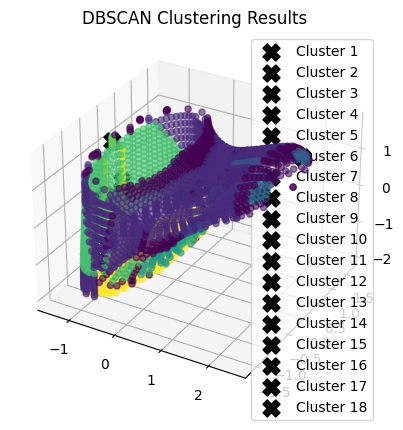

Number of clusters: 18


In [633]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm

def set_colors(labels, n_clusters):
    cmap = cm.get_cmap('viridis', n_clusters)  
    unique_labels = np.unique(labels)
    color_mapping = {label: cmap(i) for i, label in enumerate(unique_labels)}
    return [color_mapping[label] for label in labels]

# 读取数据并归一化
DataFrame = pd.read_csv(r"C:\alan\ITRI\Robot_Arm\sample_feature_points.csv", header=None)
DataMatrix = DataFrame.to_numpy()
normalized_data_matrix = skp.scale(DataMatrix, axis=0)

# 使用DBSCAN进行分群
dbscan = DBSCAN(eps=0.5, min_samples=5)  # 你可以根据数据的特点调整 eps 和 min_samples 参数
labels = dbscan.fit_predict(normalized_data_matrix)

# 获取分群数
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # 排除噪声点

# 获取基于DBSCAN结果的颜色
colors = set_colors(labels, n_clusters)

# 绘制DBSCAN分群结果
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normalized_data_matrix[:, 0], normalized_data_matrix[:, 1], normalized_data_matrix[:, 2], c=colors, alpha=0.6)

# 绘制分群的中心点（这里DBSCAN没有明确的中心点，使用每个簇的质心代替）
unique_labels = set(labels)
for label in unique_labels:
    if label != -1:  # 排除噪声点
        cluster_points = normalized_data_matrix[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        ax.scatter(centroid[0], centroid[1], centroid[2], c='k', s=150, marker='X', label='Cluster ' + str(label + 1))

plt.title('DBSCAN Clustering Results')
ax.legend()
plt.show()

print(f'Number of clusters: {n_clusters}')

In [634]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np



# 创建 3D 散点图
fig = go.Figure()

# 为每个簇定义颜色
unique_labels = np.unique(labels)
colors = [
    'blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow',
    'black', 'brown', 'pink', 'gray', 'lime', 'teal', 'navy', 'maroon',
    'olive', 'aqua', 'silver', 'gold', 'plum', 'coral', 'salmon', 'khaki',
    'tan', 'orchid', 'indigo', 'darkgreen', 'crimson', 'turquoise'
]
# colors = set_colors(labels, len(cluster_center))
# 确保颜色列表足够长
if len(unique_labels) > len(colors):
    print("Warning: The number of clusters exceeds the number of available colors.")

# 绘制每个簇的数据点
for label in unique_labels:
    cluster_points = DataMatrix[labels == label]
    fig.add_trace(go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(size=5, color=colors[label % len(colors)], opacity=1),  # 使用取模运算以避免超出颜色列表
        name=f'Cluster {label + 1}'
    ))



# 设置图形标题和轴标签
fig.update_layout(
    title='DBSCAN Clustering Results',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

# 显示图形
fig.show(renderer="browser")

# DBSCAN根據法向量進行分群後，再使用FCM進行近一步分群

In [635]:
# import numpy as np
# from sklearn.cluster import DBSCAN
# import pandas as pd
# import sklearn.preprocessing as skp

# # 讀取數據並歸一化
# DataFrame = pd.read_csv(r"C:\alan\ITRI\Robot_Arm\sample_feature_points_normal_vector.csv", header=None)
# DataMatrix = DataFrame.to_numpy()
# normalized_data_matrix = skp.scale(DataMatrix, axis=0)

# # 讀取數據並歸一化
# DataFrame_fcm = pd.read_csv(r"C:\alan\ITRI\Robot_Arm\sample_feature_points.csv", header=None)
# DataMatrix_fcm = DataFrame_fcm.to_numpy()
# normalized_data_matrix_fcm = skp.scale(DataMatrix_fcm, axis=0)

# # 第一次使用 DBSCAN 進行分群
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# initial_labels = dbscan.fit_predict(normalized_data_matrix)

# # 儲存最終的群集標籤
# final_labels = np.copy(initial_labels)

# # 迭代每個初次分群的群集
# unique_labels = set(initial_labels)  # 提取所有唯一的群集標籤
# for label in unique_labels:
#     if label == -1:
#         # 如果是噪聲點（標籤為 -1），則跳過
#         continue

#     # 提取屬於該群集的數據點
#     cluster_points = normalized_data_matrix_fcm[initial_labels == label]

#     # 如果群集中數據點少於 min_samples，則跳過
#     if len(cluster_points) < 5:
#         continue

#     # 對該群集再次進行 DBSCAN 分群
#     sub_dbscan = DBSCAN(eps=0.3, min_samples=5)  # 可以根據需要調整參數
#     sub_labels = sub_dbscan.fit_predict(cluster_points)
#     k=len(sub(cluster_points))

#     FCM_labels,center=fcm(cluster_points,k, verbose=1)

#     # 更新最終標籤，注意標籤要偏移，避免與其他群集的標籤衝突
#     # sub_labels[sub_labels != -1] += label * 1000  # 將子群集標籤偏移以區分不同群集
#     FCM_labels[FCM_labels != -1] += (label+1) * 1000  # 將子群集標籤偏移以區分不同群集

#     final_labels[initial_labels == label] = FCM_labels

# # 結果：final_labels 包含了兩次 DBSCAN 後的最終分群標籤

In [636]:
# import plotly.graph_objects as go
# import pandas as pd
# import numpy as np



# # 创建 3D 散点图
# fig = go.Figure()

# # 为每个簇定义颜色
# unique_labels = np.unique(final_labels )
# colors = [
#     'blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow',
#     'black', 'brown', 'pink', 'gray', 'lime', 'teal', 'navy', 'maroon',
#     'olive', 'aqua', 'silver', 'gold', 'plum', 'coral', 'salmon', 'khaki',
#     'tan', 'orchid', 'indigo', 'darkgreen', 'crimson'
# ]
# # colors = set_colors(labels, len(cluster_center))
# # 确保颜色列表足够长
# if len(unique_labels) > len(colors):
#     print("Warning: The number of clusters exceeds the number of available colors.")

# # 绘制每个簇的数据点
# for label in unique_labels:
#     cluster_points = DataMatrix_fcm[final_labels == label]
#     fig.add_trace(go.Scatter3d(
#         x=cluster_points[:, 0],
#         y=cluster_points[:, 1],
#         z=cluster_points[:, 2],
#         mode='markers',
#         marker=dict(size=7, color=colors[label % len(colors)], opacity=1),  # 使用取模运算以避免超出颜色列表
#         name=f'Cluster {label + 1}'
#     ))



# # 设置图形标题和轴标签
# fig.update_layout(
#     title='DBSCAN+FCM Clustering Results',
#     scene=dict(
#         xaxis_title='X Axis',
#         yaxis_title='Y Axis',
#         zaxis_title='Z Axis'
#     )
# )

# # 显示图形
# fig.show(renderer="browser")

# FCM根據法向量進行分群後，再使用DBSCAN進行近一步分群

In [637]:
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
import sklearn.preprocessing as skp

# 讀取數據並歸一化
DataFrame = pd.read_csv(r"C:\alan\ITRI\Robot_Arm\sample_feature_points_normal_vector.csv", header=None)
DataMatrix = DataFrame.to_numpy()
normalized_data_matrix = skp.scale(DataMatrix, axis=0)

# 讀取數據並歸一化
DataFrame_fcm = pd.read_csv(r"C:\alan\ITRI\Robot_Arm\sample_feature_points.csv", header=None)
DataMatrix_fcm = DataFrame_fcm.to_numpy()
normalized_data_matrix_fcm = skp.scale(DataMatrix_fcm, axis=0)

k=len(sub(normalized_data_matrix_fcm))
if k<7:
    k=7
# 第一次使用 DBSCAN 進行分群
initial_labels,center = fcm(normalized_data_matrix_fcm ,k, verbose=1)

# 儲存最終的群集標籤
final_labels = np.copy(initial_labels)

# 迭代每個初次分群的群集
unique_labels = set(initial_labels)  # 提取所有唯一的群集標籤
for label in unique_labels:
    if label == -1:
        # 如果是噪聲點（標籤為 -1），則跳過
        continue

    # 提取屬於該群集的數據點
    cluster_points = normalized_data_matrix[initial_labels == label]

    # 如果群集中數據點少於 min_samples，則跳過
    if len(cluster_points) < 5:
        continue

    # 對該群集再次進行 DBSCAN 分群
    sub_dbscan = DBSCAN(eps=0.3, min_samples=5)  # 可以根據需要調整參數
    sub_labels = sub_dbscan.fit_predict(cluster_points)


    # 更新最終標籤，注意標籤要偏移，避免與其他群集的標籤衝突
    sub_labels[sub_labels != -1] += label * 1000  # 將子群集標籤偏移以區分不同群集
    

    final_labels[initial_labels == label] = sub_labels

# 結果：final_labels 包含了兩次 DBSCAN 後的最終分群標籤

In [638]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np



# 创建 3D 散点图
fig = go.Figure()

# 为每个簇定义颜色
unique_labels = np.unique(final_labels  )
colors = [
    'blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow',
    'black', 'brown', 'pink', 'gray', 'lime', 'teal', 'navy', 'maroon',
    'olive', 'aqua', 'silver', 'gold', 'plum', 'coral', 'salmon', 'khaki',
    'tan', 'orchid', 'indigo', 'darkgreen', 'crimson'
]
# colors = set_colors(labels, len(cluster_center))
# 确保颜色列表足够长
if len(unique_labels) > len(colors):
    print("Warning: The number of clusters exceeds the number of available colors.")

# 绘制每个簇的数据点
for label in unique_labels:
    cluster_points = DataMatrix_fcm[final_labels == label]
    fig.add_trace(go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(size=7, color=colors[label % len(colors)], opacity=1),  # 使用取模运算以避免超出颜色列表
        name=f'Cluster {label + 1}'
    ))



# 设置图形标题和轴标签
fig.update_layout(
    title='FCM+DBSCAN Clustering Results',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

# 显示图形
fig.show(renderer="browser")